# GitHub repositories analysis

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

## Read the data

In [2]:
files = glob.glob("./data/**/*.csv", recursive=True)
print("Encontrados", len(files), "ficheros")

Encontrados 41 ficheros


In [3]:
df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

In [4]:
df["date"] = pd.to_datetime(df["ts"], format='%Y-%m-%d')

In [5]:
ts_max = df["ts"].unique().max()
today = df[df.ts==ts_max]
head_total = 5 if today.ts.count()>5 else today.ts.count()

In [6]:
columns=["name","views_total","views_uniques","clones_total"]
today[columns].sort_values(by=["views_total","views_uniques"], ascending=False).head(head_total)

,name,views_total,views_uniques,clones_total
265,kotlin-ktor,13,1,0
266,mqtt-golang-influxdb,10,1,0
267,quarkus-kotlin-example,3,1,0
262,golang-rest-api-cassandra,0,0,17
263,iot-devices-crud,0,0,17


In [7]:
repos = df.name.unique().tolist()

In [8]:
dict_df_repos = dict()
for repo_name in repos:
    dict_df_repos[repo_name] = df[df.name==repo_name]

## Data analysis

In [9]:
df_grouped = df.groupby(['name']).agg({"date": ["min"], "stars_count": ["max"],"clones_uniques": ["sum"],"views_total": ["sum", "max"]})

### Views

In [10]:
views_best_quantile = 0.75
views_worst_quantile = 0.25
best_views_percentile = df_grouped[('views_total', 'sum')].quantile(views_best_quantile)
worst_views_percentile = df_grouped[('views_total', 'sum')].quantile(views_worst_quantile)
print("Best views over:", best_views_percentile)
print("Worst views under:", worst_views_percentile)

Best views over: 27.0
Worst views under: 0.0


In [11]:
views=df_grouped[('views_total')]
views_best = views[views['sum'] > best_views_percentile]
views_best.sort_values(by='sum', ascending=False)

,sum,max
name,,
kotlin-ktor,299,41
ocp-monitoring-golang,172,133
quarkus-kotlin-example,162,46
ml-github,129,41
golang-rest-api-cassandra,84,27
mqtt-golang-influxdb,80,25
golang-k8s-helm-helloworld,61,42
istio-wasm-filter-golang,56,8
b0rr3g0-blog,52,48


#### Best views repositories

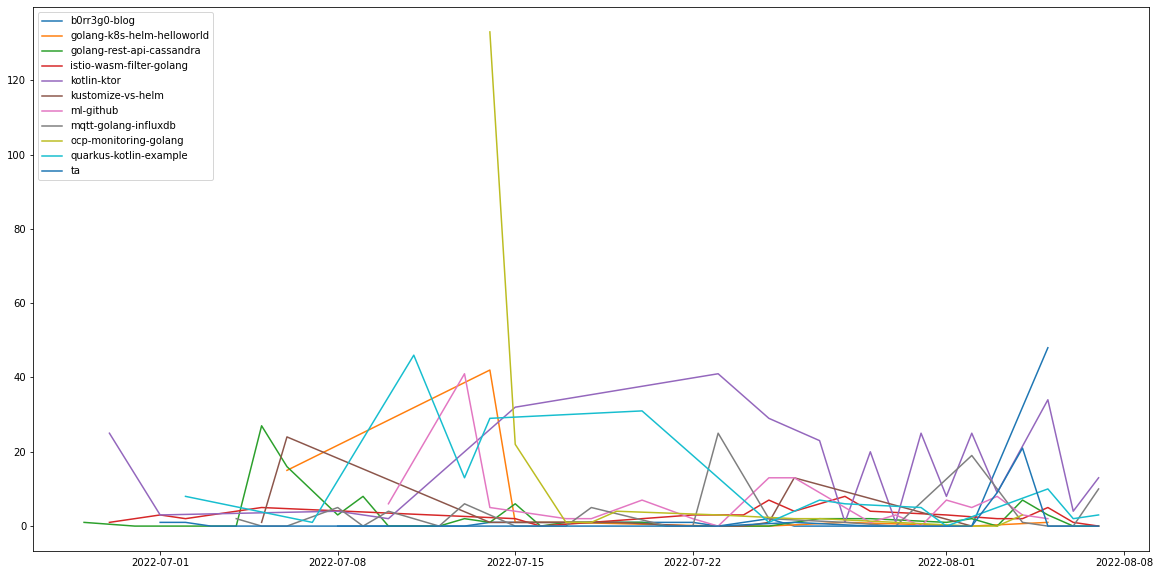

In [12]:
plt.figure(figsize=(20,10))
for repo_name in views_best.index.tolist():
    df_r = dict_df_repos[repo_name].sort_values(by="date")
    x = df_r.date
    y = df_r.views_total
    plt.plot(x, y, label=repo_name)
    
plt.legend(loc = "upper left")

#### Sum views total

In [13]:
df_total_views=df.groupby(['date']).agg({"views_total": ["sum"]}).sort_values(by="date", ascending=True)

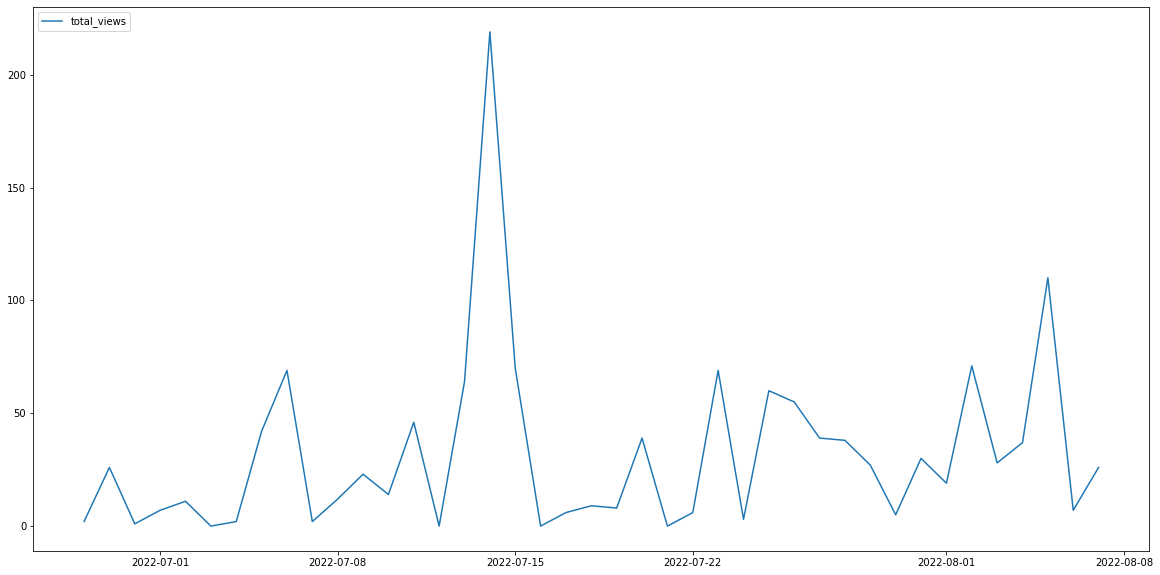

In [14]:
plt.figure(figsize=(20,10))
x = df_total_views.index
y = df_total_views[('views_total', 'sum')]
plt.plot(x, y, label="total_views")
plt.legend(loc = "upper left")

### Clones

In [15]:
# calculate the best 25% repositories
best_clones_quantile = 0.75
worst_clones_quantile = 0.25
best_clones_percentile = df_grouped[('clones_uniques', 'sum')].quantile(best_clones_quantile)
worst_clones_percentile = df_grouped[('clones_uniques', 'sum')].quantile(worst_clones_quantile)
print("Best clones over:", best_clones_percentile)
print("Worst clones under:", worst_clones_percentile)

Best clones over: 4.0
Worst clones under: 1.0


In [16]:
clones=df_grouped[('clones_uniques')]
clones_best = clones[clones['sum'] > best_clones_percentile]
clones_best.sort_values(by='sum', ascending=False)

,sum
name,
golang-rest-api-cassandra,567
ta,448
iot-devices-crud,284
mqtt-golang-influxdb,214
ml-github,67
ocp-monitoring-golang,11
DO180-apps,10
b0rr3g0-blog,10
istio-wasm-filter-golang,6


# Stars

In [17]:
# calculate the best 50% repositories
best_stars_quantile = 0.75
worst_stars_quantile = 0.25
best_stars_percentile = df_grouped[('stars_count', 'max')].quantile(best_stars_quantile)
worst_stars_percentile = df_grouped[('stars_count', 'max')].quantile(worst_stars_quantile)
print("Best stars over:", best_stars_percentile)
print("Worst stars under:", worst_stars_percentile)

Best stars over: 1.0
Worst stars under: 0.0


In [18]:
stars=df_grouped[('stars_count')]
stars_best = stars[stars['max'] > best_stars_percentile]
stars_best.sort_values(by=['max'], ascending=False)

,max
name,
mqtt-golang-influxdb,11
kotlin-ktor,6
spring-kotlin-crud,6
kops-aws,4
kustomize-vs-helm,3
ta,3
golang-k8s-helm-helloworld,2
golang-rest-api-cassandra,2
quarkus-kotlin-example,2


# Red zone

In [173]:
repos = pd.read_csv("./repos.csv")

# remove colum
repos = repos.iloc[:,1:]
# remove owner
repos = repos.drop(labels="owner",axis=1)
# add num topics
#repos["num_topics"] = len(repos.topics.str.split(','))
def count_topics(topics):
    return 0 if topics.count(',') == 0 else topics.count(',')+1
repos["topics_count"] = repos.apply(lambda row : count_topics(row.topics), axis=1)
# remove topics
repos = repos.drop(labels="topics",axis=1)
# format date
repos["latest_commit_date"] = pd.to_datetime(repos["latest_commit_date"], format='%Y%m%d')
# days until latest commit
today = pd.to_datetime('today')
repos["days_latest_commit"] = (today - repos.latest_commit_date).dt.days
# views
def views_total(name):
    try:
        return df_grouped.loc[name][('views_total', 'sum')]
    except Exception as e:
        print("Error ", name, " ==> ", e)
        return 0
repos["views_total"] = repos.apply(lambda row: views_total(row["name"]), axis=1)

Error  beautifulhugo  ==>  'beautifulhugo'
Error  cd-travis-app  ==>  'cd-travis-app'
Error  clover  ==>  'clover'
Error  docker-elk  ==>  'docker-elk'
Error  git-changelog-maven-plugin  ==>  'git-changelog-maven-plugin'
Error  github-traffic  ==>  'github-traffic'
Error  helm-spring-boot-chart  ==>  'helm-spring-boot-chart'
Error  icepie  ==>  'icepie'
Error  influx-telegraf-chronograf  ==>  'influx-telegraf-chronograf'
Error  iot-esp8266-dht11  ==>  'iot-esp8266-dht11'
Error  iot-esp8266-relay-web-server  ==>  'iot-esp8266-relay-web-server'
Error  iot-k8s-stack  ==>  'iot-k8s-stack'
Error  istio  ==>  'istio'
Error  java8-tutorial  ==>  'java8-tutorial'
Error  jenkins-ci  ==>  'jenkins-ci'
Error  kubernetes-golang-operator  ==>  'kubernetes-golang-operator'
Error  kubernetes-pipeline-plugin  ==>  'kubernetes-pipeline-plugin'
Error  library  ==>  'library'
Error  ms-config-server  ==>  'ms-config-server'
Error  petclinic-config  ==>  'petclinic-config'
Error  poc-k8s-ambassador  ==>  

In [174]:
df_grouped.loc['golang-azure-eventhub'][('date', 'min')]

Timestamp('2022-07-16 00:00:00')

In [175]:
def extract_views_by_day(row):
    return 
repos["views_by_day"] = repos.apply(lambda row: extract_views_by_day(row.name),axis=1)

In [180]:
# Scores by labels
cut_labels = ['S','A', 'B', 'C']
cut_bins = [0, 7, 30, 365, 99999]
repos['score_commits'] = pd.cut(repos['days_latest_commit'], bins=cut_bins, labels=cut_labels)

# Topics value
cut_labels = [False,True]
cut_bins = [-1, 0, 99999]
repos['score_topics'] = pd.cut(repos['topics_count'], bins=cut_bins, labels=cut_labels)

# Views score
cut_labels = ['C', 'B', 'A', 'S']
# rank for zero values
repos['views_total'] = repos['views_total'].rank(method='min')
cut_bins = [0, 
            repos['views_total'].quantile(q=0.25),
            repos['views_total'].quantile(q=0.75),
            repos['views_total'].quantile(q=0.9),
            repos['views_total'].quantile(q=1)]
print(cut_bins)
repos['score_views'] = pd.cut(repos['views_total'], bins=cut_bins, labels=cut_labels)
repos['score_views'].unique()

[0, 1.0, 55.5, 66.7, 74.0]


['C', 'B', 'A', 'S']
Categories (4, object): ['C' < 'B' < 'A' < 'S']

In [181]:
repos.sort_values(by="days_latest_commit").head(5)

,name,latest_commit_date,topics_count,days_latest_commit,views_total,views_by_day,score_commits,score_topics,score_views
42,ml-github,2022-08-05,0,3,71.0,None,S,False,S
3,b0rr3g0-blog,2022-07-26,0,13,66.0,None,A,False,A
35,kops-aws,2022-07-26,0,13,63.0,None,A,False,A
48,ocp-monitoring-golang,2022-07-14,0,25,73.0,None,A,False,S
15,golang-k8s-helm-helloworld,2022-07-14,5,25,68.0,None,A,True,S


In [187]:
table_columns = ['name', 'score_commits', 'score_topics', 'score_views']
table = repos[table_columns]
color_c = 'background-color: #c91e1e;'
color_b = 'background-color: #ffc258;'
color_a = 'background-color: #9bc2fd;'
color_s = 'background-color: #5e9400;'
style = table.style.set_table_styles([  
    {'selector': '.S', 'props': color_s},
    {'selector': '.A', 'props': color_a},
    {'selector': '.B', 'props': color_b},
    {'selector': '.C', 'props': color_c},
    {'selector': '.False', 'props': color_c},
    {'selector': '.True', 'props': color_s},
], overwrite=False)

cell_color = pd.DataFrame(table[table_columns],
                          index=repos.index)

style.set_td_classes(cell_color)


,name,score_commits,score_topics,score_views
0,amq-streams-workshop,B,False,C
1,ansible-base,B,False,B
2,asciidoc-base,B,False,C
3,b0rr3g0-blog,A,False,A
4,beautifulhugo,B,False,C
5,cd-travis-app,C,False,C
6,clover,B,False,C
7,dbgjerez,B,False,C
8,DO180-apps,C,False,B
9,docker-elk,C,False,C


In [183]:
df_red_zone = df_grouped[df_grouped[('stars_count', 'max')] <= worst_stars_percentile]
df_red_zone = df_red_zone[df_red_zone[('clones_uniques', 'sum')] <= worst_clones_percentile]
df_red_zone = df_red_zone[df_red_zone[('views_total', 'sum')] <= worst_views_percentile]
df_red_zone.index.values.tolist()

['golang-azure-eventhub',
 'golang-azure-eventhub-kafka',
 'kubernetes-helm-operator',
 'spring-cloud-config',
 'spring-cloud-dataflow',
 'spring-cloud-eureka',
 'tinygo-site',
 'uca-workshop-docker']